In [7]:
## Imports libs
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
print(tf.__version__) 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import itertools
import random
import os
import math # Mathematical functions 


2.2.0


In [8]:
data =  pd.read_csv('./dataset/bitcoin/bitcoin_30min_dataset.csv', header=0)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40907 entries, 0 to 40906
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        40907 non-null  object 
 1   Open        40907 non-null  float64
 2   High        40907 non-null  float64
 3   Low         40907 non-null  float64
 4   Close       40907 non-null  float64
 5   SMAVG_50d   40907 non-null  float64
 6   SMAVG_100d  40907 non-null  float64
 7   SMAVG_200d  40907 non-null  float64
dtypes: float64(7), object(1)
memory usage: 2.5+ MB


In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data=data.sort_values(by="Date", ascending=True)
data.set_index("Date",inplace=True)
data=data[(data.index >= '2022-04-01') & (data.index <= '2022-09-30')]

In [11]:
data.head()

,Open,High,Low,Close,SMAVG_50d,SMAVG_100d,SMAVG_200d
Date,,,,,,,
2022-04-01 00:00:00,45807.09,45808.32,45633.79,45696.46,46714.15,46991.26,47165.98
2022-04-01 00:30:00,45696.46,45731.87,45231.34,45528.45,46682.70,46973.66,47169.38
2022-04-01 01:00:00,45528.45,45644.90,45435.24,45619.80,46651.65,46957.45,47173.64
2022-04-01 01:30:00,45619.80,45646.91,45372.02,45551.16,46621.20,46939.40,47170.98
2022-04-01 02:00:00,45551.16,45551.16,45152.82,45161.37,46580.79,46916.62,47164.52


### Select Features

In [12]:
data_prices = data.drop(['SMAVG_100d'], axis=1)

In [13]:
data_prices

,Open,High,Low,Close,SMAVG_50d,SMAVG_200d
Date,,,,,,
2022-04-01 00:00:00,45807.09,45808.32,45633.79,45696.46,46714.15,47165.98
2022-04-01 00:30:00,45696.46,45731.87,45231.34,45528.45,46682.70,47169.38
2022-04-01 01:00:00,45528.45,45644.90,45435.24,45619.80,46651.65,47173.64
2022-04-01 01:30:00,45619.80,45646.91,45372.02,45551.16,46621.20,47170.98
2022-04-01 02:00:00,45551.16,45551.16,45152.82,45161.37,46580.79,47164.52
...,...,...,...,...,...,...
2022-09-29 22:00:00,19508.14,19519.25,19475.84,19491.22,19406.72,19288.22
2022-09-29 22:30:00,19491.22,19493.13,19423.25,19432.78,19404.02,19290.35
2022-09-29 23:00:00,19432.70,19536.98,19423.87,19462.57,19399.05,19292.77


In [14]:
# We add a prediction column and set dummy values to prepare the data for scaling
data_prices_ext = data_prices.copy()
data_prices_ext['Prediction'] = data_prices_ext['Close']

# Print the tail of the dataframe
data_prices_ext.tail()

,Open,High,Low,Close,SMAVG_50d,SMAVG_200d,Prediction
Date,,,,,,,
2022-09-29 22:00:00,19508.14,19519.25,19475.84,19491.22,19406.72,19288.22,19491.22
2022-09-29 22:30:00,19491.22,19493.13,19423.25,19432.78,19404.02,19290.35,19432.78
2022-09-29 23:00:00,19432.70,19536.98,19423.87,19462.57,19399.05,19292.77,19462.57
2022-09-29 23:30:00,19462.29,19481.30,19422.57,19460.94,19395.95,19295.39,19460.94
2022-09-30 00:00:00,19463.22,19504.95,19433.48,19497.20,19394.90,19297.99,19497.20


### Scaling the Multivariate Input Data

In [15]:
# Get the number of rows in the data
nrows = data_prices.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_prices)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_prices_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(8737, 6)


In [16]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 6

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(6984, 6, 6) (6984,)
(1747, 6, 6) (1747,)
0.9106686942200547
0.9106686942200547


### Train LSTM Model

In [17]:
# ------------------LSTM-----------------------
regressor = Sequential()
regressor.add(LSTM(units=16, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=16, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 16)             1472      
_________________________________________________________________
dropout (Dropout)            (None, 6, 16)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 3,601
Trainable params: 3,601
Non-trainable params: 0
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit model
history = regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=64, callbacks=[es])

Epoch 1/40
77/77 [==============================] - 2s 30ms/step - loss: 0.0269 - root_mean_squared_error: 0.1639 - val_loss: 1.0896e-04 - val_root_mean_squared_error: 0.0104
Epoch 2/40
77/77 [==============================] - 1s 10ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 7.5286e-05 - val_root_mean_squared_error: 0.0087
Epoch 3/40
77/77 [==============================] - 1s 10ms/step - loss: 0.0065 - root_mean_squared_error: 0.0807 - val_loss: 1.0629e-04 - val_root_mean_squared_error: 0.0103
Epoch 4/40
77/77 [==============================] - 1s 11ms/step - loss: 0.0060 - root_mean_squared_error: 0.0772 - val_loss: 6.2910e-05 - val_root_mean_squared_error: 0.0079
Epoch 5/40
77/77 [==============================] - 1s 11ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 1.8596e-04 - val_root_mean_squared_error: 0.0136
Epoch 6/40
77/77 [==============================] - 1s 11ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704 - val_loss:

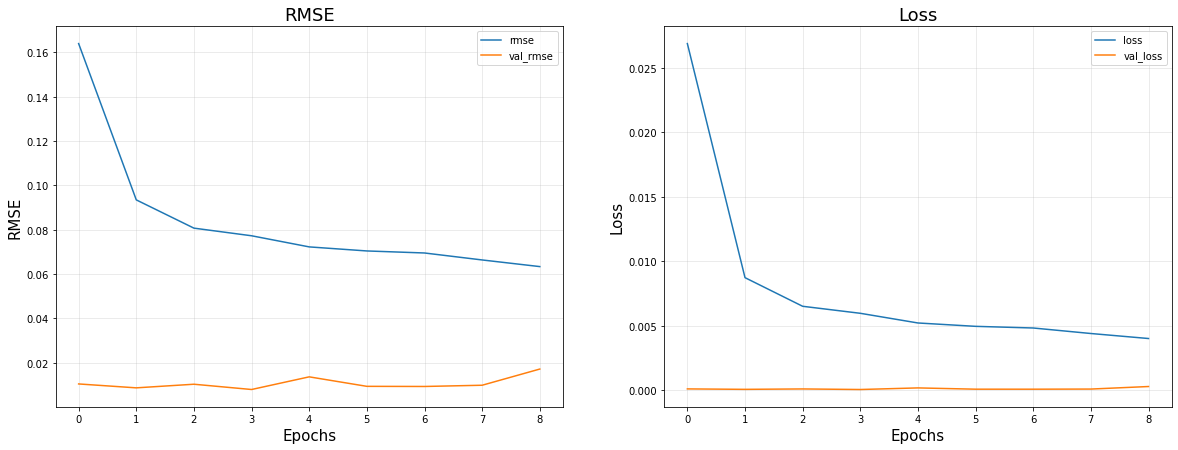

In [19]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [20]:
results = regressor.evaluate(x_test, y_test)
print("test loss, test acc:", np.round(results, 4))

55/55 [==============================] - 0s 2ms/step - loss: 7.1912e-05 - root_mean_squared_error: 0.0085
test loss, test acc: [0.0001 0.0085]


### Hyperparameter Tunning

In [21]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))
    
    print(possible_combinations)
    print('\n')
    
    hist = []
    
    for i in range(0, len(possible_combinations)):
        
        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')
        
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
        
        # instantiating the model in the strategy scope creates the model on the TPU
        #with tpu_strategy.scope():
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(GRU(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
        '''''
        From the mentioned article above --> If a validation dataset is specified to the fit() function via the validation_data or v
        alidation_split arguments,then the loss on the validation dataset will be made available via the name “val_loss.”
        '''''

        file_path = 'best_model.h5'

        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        '''''
        cb = Callback(...)  # First, callbacks must be instantiated.
        cb_list = [cb, ...]  # Then, one or more callbacks that you intend to use must be added to a Python list.
        model.fit(..., callbacks=cb_list)  # Finally, the list of callbacks is provided to the callback argument when fitting the model.
        '''''

        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # load the best model
        # regressor = load_model('best_model.h5')

        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
        
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
         
    return hist

In [22]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]  

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test)  # change x_train shape

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 00001: val_loss improved from inf to 0.00010, saving model to best_model.h5

Epoch 00002: val_loss improved from 0.00010 to 0.00008, saving model to best_model.h5

Epoch 00003: val_loss improved from 0.00008 to 0.00007, saving model to best_model.h5

Epoch 00004: val_loss improved from 0.00007 to 0.00005, saving model to best_model.h5

Epoch 00005: val_loss did not improve from 0.00005

Epoch 00006: val_loss did not improve from 0.00005

Epoch 00007: val_loss did not improve from 0.00005

Epoch 00008: val_loss did not improve from 0.00005

Epoch 00009: val_loss did not improve from 0.00005
Epoch 00009: early stopping
0-th combination = (False, False, False, 16, 8, 0.2) 
 train ac


Epoch 00010: val_loss did not improve from 0.00004

Epoch 00011: val_loss did not improve from 0.00004

Epoch 00012: val_loss did not improve from 0.00004

Epoch 00013: val_loss did not improve from 0.00004
Epoch 00013: early stopping
5-th combination = (False, False, False, 32, 32, 0.2) 
 train accuracy: [0.00014983957225922495, 0.012240897864103317] and test accuracy: [6.076910358387977e-05, 0.007795454002916813]
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
--------------------------------------------------------------------
